## Preambule

In [213]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import json
import os
from scipy.optimize import curve_fit
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import n_colors
from scipy.ndimage import convolve1d

## Parameters

In [214]:
params = dict(pcc_conv_start = 2040,
              pcc_conv_end = 2150,
              convergence_year_gdr= 2150,
              convergence_year_base= 2150,
              historical_emissions_startyear= 1990,
              discount_factor= 0.015,
              version_ndcs="13Mar2023a",
              gwp_ch4= 27.2,
              gwp_n2o= 273,
              start_year_analysis=2021,
              global_carbon_budget_2022_15=420, # https://essd.copernicus.org/articles/14/1917/2021/, in Gt CO2
              global_carbon_budget_2022_17=770,
              global_carbon_budget_2022_20=1270,
              global_carbon_budget_2022_25=1270+500,
              global_carbon_budget_2022_30=1270+1000)

In [215]:
standard_settings = dict(Risk_of_exceedance='50%',
                         Negative_emissions='Medium',
                         Non_CO2_mitigation_potential='Medium')

standard_settings_ndc = dict(Hot_air='include',
                             Conditionality='unconditional')

In [216]:
paths = dict(data_external = "X:/user/dekkerm/Data/",
             data_baseline = "X:/user/heerdenvr/Downscaling/Mark/",
             task = 'X:/user/dekkerm/Projects/ECEMF_T5.2/',
             data = "../Data/")

## Read data

General stuff

In [217]:
df_gen = pd.read_excel(paths['data_external']+"UNFCCC_Parties_Groups_noeu.xlsx", sheet_name = "Country groups")
countries_iso = np.array(list(df_gen["Country ISO Code"]))
countries_name = np.array(list(df_gen["Name"]))
regions_iso = np.array(list(df_gen["Country ISO Code"]) + ['EU', 'WORLD'])
regions_name = np.array(list(df_gen["Name"])+['World'])

np.save(paths['data'] + "all_regions.npy", regions_iso)
np.save(paths['data'] + "all_regions_names.npy", regions_name)
np.save(paths['data'] + "all_countries.npy", countries_iso)
np.save(paths['data'] + "all_countries_names.npy", countries_name)

GDP and Population (SSP database)

In [218]:
df_ssp = pd.read_csv(paths['data_external']+"SSPs/SspDb_country_data_2013-06-12.csv")
df_ssp = df_ssp[(df_ssp.MODEL == 'OECD Env-Growth') & (df_ssp.SCENARIO.isin(['SSP1_v9_130325', 'SSP2_v9_130325', 'SSP3_v9_130325', 'SSP4_v9_130325', 'SSP5_v9_130325']))]
Scenario = np.array(df_ssp['SCENARIO'])
Scenario[Scenario == 'SSP1_v9_130325'] = 'SSP1'
Scenario[Scenario == 'SSP2_v9_130325'] = 'SSP2'
Scenario[Scenario == 'SSP3_v9_130325'] = 'SSP3'
Scenario[Scenario == 'SSP4_v9_130325'] = 'SSP4'
Scenario[Scenario == 'SSP5_v9_130325'] = 'SSP5'
df_ssp['SCENARIO'] = Scenario
Variable = np.array(df_ssp['VARIABLE'])
Variable[Variable == 'GDP|PPP'] = 'GDP'
df_ssp['VARIABLE'] = Variable
df_ssp = df_ssp.drop(['MODEL', 'UNIT'], axis=1)
df_ssp = df_ssp.rename(columns={'SCENARIO': "Scenario", 'REGION': 'Region', 'VARIABLE': 'Variable'})
dummy = df_ssp.melt(id_vars=["Scenario", "Region", "Variable"], var_name="Time", value_name="Value")
dummy['Time'] = np.array(dummy['Time'].astype(int))
xr_ssp = xr.Dataset.from_dataframe(dummy.pivot(index=['Scenario', 'Region', 'Time'], columns='Variable', values='Value'))

UN population (for pre-2000 population data)

In [219]:
df_unp = pd.read_excel(paths['data_external']+'/UN Population/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS.xlsx', sheet_name="Estimates", header=16)
df_unp = df_unp[["Region, subregion, country or area *", "ISO3 Alpha-code", "Total Population, as of 1 January (thousands)", "Year"]]
df_unp = df_unp.rename(columns={"Region, subregion, country or area *": "Region", "ISO3 Alpha-code": "ISO", "Total Population, as of 1 January (thousands)": "Population", "Year": "Time"})
vals = np.array(df_unp.Population).astype(str)
vals[vals == '...'] = 'nan'
vals = vals.astype(float)
vals = vals/1e3
df_unp['Population'] = vals
df_unp = df_unp.drop(['Region'], axis=1)
df_unp = df_unp[df_unp.Time < 2000]
df_unp = df_unp[df_unp.ISO.isin(regions_iso)]
dummy = df_unp.rename(columns={'ISO': "Region"})
dummy = dummy.set_index(['Region', 'Time'])
xr_unp = xr.Dataset.from_dataframe(dummy)

AR6

In [220]:
df_ar6 = pd.read_csv(paths['data_external']+"IPCC/AR6_Scenarios_Database_World_v1.1.csv")
df_ar6 = df_ar6[df_ar6.Variable == 'Emissions|CO2|Energy and Industrial Processes']
df_ar6 = df_ar6.reset_index(drop=True)
df_ar6_meta = pd.read_excel(paths['data_external']+"IPCC/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx", sheet_name='meta_Ch3vetted_withclimate')
mods = np.array(df_ar6_meta.Model)
scens = np.array(df_ar6_meta.Scenario)
modscens_meta = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_meta['ModelScenario'] = modscens_meta
df_ar6_meta = df_ar6_meta[['ModelScenario', 'Category', 'Policy_category']]
mods = np.array(df_ar6.Model)
scens = np.array(df_ar6.Scenario)
modscens = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6['ModelScenario'] = modscens
df_ar6 = df_ar6.drop(['Model', 'Scenario', 'Region', 'Variable', 'Unit'], axis=1)

# Compute average trajectory for each C-category
rows = []
for c_i, c in enumerate(np.unique(df_ar6_meta.Category)):
    rows.append([c]+list(np.mean(np.array(df_ar6[df_ar6.ModelScenario.isin(np.array(df_ar6_meta[df_ar6_meta.Category.isin([c])].ModelScenario))][df_ar6.keys()[:-1]]), axis=0)))
df_scen = pd.DataFrame(rows, columns=['Category']+list(df_ar6.keys()[:-1]))
df_scen['Variable'] = ['CO2 (scen)']*len(df_scen)
dummy = df_scen.melt(id_vars=["Category", "Variable"], var_name="Time", value_name="Value")
dummy['Time'] = np.array(dummy['Time'].astype(int))
dummy = dummy.set_index(["Category", "Variable", "Time"])
xr_scen2 = xr.Dataset.from_dataframe(dummy)

In [221]:
# Translate to 1.5, 1.7 and 2.0 budgets
av_paris = xr_scen2.sel(Category=['C1', 'C2', 'C3']).mean(dim='Category')
av_paris = av_paris.reindex(Time = np.arange(2000, 2101))
av_paris = av_paris.interpolate_na(dim="Time", method="linear")
av_paris = av_paris.reindex(Time = np.arange(params['start_year_analysis'], 2101))
compensation_form = (-1+np.arange(1, 2101-params['start_year_analysis']+1)**0.25)
factor_15 = (params['global_carbon_budget_2022_15'] - np.nansum(av_paris.Value)/1e3 ) / np.sum(compensation_form)
factor_17 = (params['global_carbon_budget_2022_17'] - np.nansum(av_paris.Value)/1e3 ) / np.sum(compensation_form)
factor_20 = (params['global_carbon_budget_2022_20'] - np.nansum(av_paris.Value)/1e3 ) / np.sum(compensation_form)
factor_25 = (params['global_carbon_budget_2022_25'] - np.nansum(av_paris.Value)/1e3 ) / np.sum(compensation_form)
factor_30 = (params['global_carbon_budget_2022_30'] - np.nansum(av_paris.Value)/1e3 ) / np.sum(compensation_form)
rows = []
for c_i, c in enumerate(['1.5 deg', '1.7 deg', '2.0 deg', '2.5 deg', '3.0 deg']):
    rows.append([c]+list(1e3*np.array(av_paris.Value/1e3+compensation_form*[factor_15, factor_17, factor_20, factor_25, factor_30][c_i])[0]))
df_scen = pd.DataFrame(rows, columns=['Temperature']+list(np.array(av_paris.Time)))
df_scen['Risk_of_exceedance'] = '50%'
df_scen['Negative_emissions'] = 'Medium'
df_scen['Non_CO2_mitigation_potential'] = 'Medium'
dummy = df_scen.melt(id_vars=["Temperature", "Risk_of_exceedance", "Negative_emissions", "Non_CO2_mitigation_potential"], var_name="Time", value_name="CO2_globe")
dummy['Time'] = np.array(dummy['Time'].astype(int))
dummy = dummy.set_index(["Temperature", "Risk_of_exceedance", "Negative_emissions", "Non_CO2_mitigation_potential", "Time"])
xr_scen = xr.Dataset.from_dataframe(dummy)

AR6 regional

In [222]:
df_ar6_w = pd.read_csv(paths['data_external']+"IPCC/AR6_Scenarios_Database_World_v1.1.csv")
df_ar6_w = df_ar6_w[df_ar6_w.Variable == 'Emissions|CO2|Energy and Industrial Processes']
df_ar6_w = df_ar6_w.reset_index(drop=True)
mods = np.array(df_ar6_w.Model)
scens = np.array(df_ar6_w.Scenario)
modscens = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_w['ModelScenario'] = modscens
df_ar6_w = df_ar6_w.drop(['Model', 'Scenario', 'Variable', 'Unit'], axis=1)

In [223]:
df_ar6_reg = pd.read_csv(paths['data_external']+"IPCC/AR6_ISO3/AR6_Scenarios_Database_ISO3_v1.1.csv")
df_ar6_reg = df_ar6_reg[df_ar6_reg.Variable == 'Emissions|CO2|Energy and Industrial Processes']
df_ar6_reg = df_ar6_reg.reset_index(drop=True)
df_ar6_reg_meta = pd.read_excel(paths['data_external']+"IPCC/AR6_ISO3/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx", sheet_name='meta_Ch3vetted_withclimate')
mods = np.array(df_ar6_reg_meta.Model)
scens = np.array(df_ar6_reg_meta.Scenario)
modscens_meta = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_reg_meta['ModelScenario'] = modscens_meta
df_ar6_reg_meta = df_ar6_reg_meta[['ModelScenario', 'Category', 'Policy_category']]
mods = np.array(df_ar6_reg.Model)
scens = np.array(df_ar6_reg.Scenario)
modscens = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_reg['ModelScenario'] = modscens
df_ar6_reg = df_ar6_reg.drop(['Model', 'Scenario', 'Variable', 'Unit'], axis=1)
df_ar6_reg = df_ar6_reg[df_ar6_reg.ModelScenario.isin(np.array(df_ar6_reg_meta[df_ar6_reg_meta.Category.isin(['C1', 'C2', 'C3'])].ModelScenario))]
df_ar6_reg = df_ar6_reg.reset_index(drop=True)

In [224]:
dummy = df_ar6_reg.melt(id_vars=["Region", "ModelScenario"], var_name="Time", value_name="CO2")
dummy['Time'] = np.array(dummy['Time'].astype(int))
dummy = dummy.set_index(["Region", "ModelScenario", "Time"])
xr_ar6_reg = xr.Dataset.from_dataframe(dummy)
xr_ar6_reg = xr_ar6_reg.reindex(Time = np.arange(1850, 2101))
xr_ar6_reg = xr_ar6_reg.interpolate_na(dim="Time", method="linear")

dummy = df_ar6_w.melt(id_vars=["Region", "ModelScenario"], var_name="Time", value_name="CO2")
dummy['Time'] = np.array(dummy['Time'].astype(int))
dummy = dummy.set_index(["Region", "ModelScenario", "Time"])
xr_ar6_w = xr.Dataset.from_dataframe(dummy)
xr_ar6_w = xr_ar6_w.reindex(Time = np.arange(1850, 2101))
xr_ar6_w = xr_ar6_w.interpolate_na(dim="Time", method="linear")

In [225]:
percs_cobud = xr_ar6_reg.sel(Time=np.arange(params['start_year_analysis'], 2101)).sum(dim='Time') / xr_ar6_w.sel(Time=np.arange(params['start_year_analysis'], 2101)).sum(dim='Time').sel(Region='World')
percs_cobud = percs_cobud.where(percs_cobud.CO2!=0, np.nan)

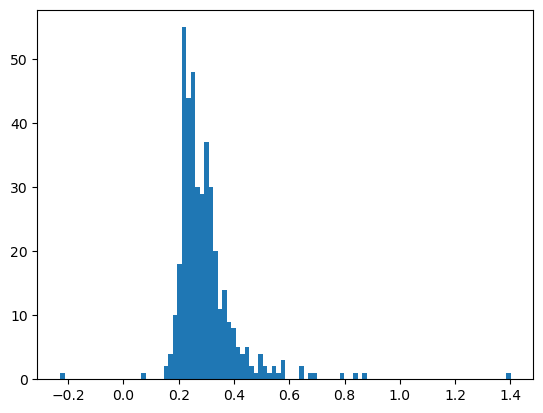

In [226]:
plt.hist(percs_cobud.sel(Region='CHN').CO2, bins=100)
plt.show()

In [227]:
data = np.array([np.array(percs_cobud.CO2.quantile(0.05, dim='ModelScenario')),
        np.array(percs_cobud.CO2.quantile(0.50, dim='ModelScenario')),
        np.array(percs_cobud.CO2.quantile(0.95, dim='ModelScenario'))])
coords = {
    'Region': percs_cobud.Region,
    'Costoptimal_range': ['Low', 'Median', 'High'],
}
data_vars = {
    'Percs': (['Region', 'Costoptimal_range'], data.T),
}
xr_percs = xr.Dataset(data_vars, coords=coords)
budgets_reg = xr_percs.Percs*xr_scen.CO2_globe.sel(Time=np.arange(params['start_year_analysis'], 2101)).sum(dim='Time')

In [228]:
av_paris_reg15 = xr_ar6_reg.sel(ModelScenario=np.intersect1d(xr_ar6_reg.ModelScenario, np.array(df_ar6_reg_meta.ModelScenario[df_ar6_reg_meta.Category == 'C1']))).median(dim='ModelScenario').sel(Time=np.arange(params['start_year_analysis'], 2101))
av_paris_reg17 = xr_ar6_reg.sel(ModelScenario=np.intersect1d(xr_ar6_reg.ModelScenario, np.array(df_ar6_reg_meta.ModelScenario[df_ar6_reg_meta.Category == 'C2']))).median(dim='ModelScenario').sel(Time=np.arange(params['start_year_analysis'], 2101))
av_paris_reg20 = xr_ar6_reg.sel(ModelScenario=np.intersect1d(xr_ar6_reg.ModelScenario, np.array(df_ar6_reg_meta.ModelScenario[df_ar6_reg_meta.Category == 'C3']))).median(dim='ModelScenario').sel(Time=np.arange(params['start_year_analysis'], 2101))
av_paris_reg25 = xr_ar6_reg.sel(ModelScenario=np.intersect1d(xr_ar6_reg.ModelScenario, np.array(df_ar6_reg_meta.ModelScenario[df_ar6_reg_meta.Category == 'C5']))).median(dim='ModelScenario').sel(Time=np.arange(params['start_year_analysis'], 2101))
av_paris_reg30 = xr_ar6_reg.sel(ModelScenario=np.intersect1d(xr_ar6_reg.ModelScenario, np.array(df_ar6_reg_meta.ModelScenario[df_ar6_reg_meta.Category == 'C6']))).median(dim='ModelScenario').sel(Time=np.arange(params['start_year_analysis'], 2101))

In [229]:
compensation_form = (xr_scen.Time.sel(Time=np.arange(params['start_year_analysis'], 2101))-params['start_year_analysis']+1)**0.25-1
factor15 = ((budgets_reg-av_paris_reg15.sum(dim='Time')) / compensation_form.sum()).sel(Temperature='1.5 deg')
factor17 = ((budgets_reg-av_paris_reg17.sum(dim='Time')) / compensation_form.sum()).sel(Temperature='1.7 deg')
factor20 = ((budgets_reg-av_paris_reg20.sum(dim='Time')) / compensation_form.sum()).sel(Temperature='2.0 deg')
factor25 = ((budgets_reg-av_paris_reg17.sum(dim='Time')) / compensation_form.sum()).sel(Temperature='2.5 deg')
factor30 = ((budgets_reg-av_paris_reg20.sum(dim='Time')) / compensation_form.sum()).sel(Temperature='3.0 deg')
data = np.array([(av_paris_reg15 + compensation_form*factor15).CO2,
                 (av_paris_reg17 + compensation_form*factor17).CO2,
                 (av_paris_reg20 + compensation_form*factor20).CO2,
                 (av_paris_reg25 + compensation_form*factor25).CO2,
                 (av_paris_reg30 + compensation_form*factor30).CO2])
dummy = (av_paris_reg15 + compensation_form*factor15)
coords = {
    'Time': dummy.Time,
    'Region': dummy.Region,
    'Costoptimal_range': dummy.Costoptimal_range,
    'Risk_of_exceedance': dummy.Risk_of_exceedance,
    'Negative_emissions': dummy.Negative_emissions,
    'Non_CO2_mitigation_potential': dummy.Non_CO2_mitigation_potential,
    'Temperature': ['1.5 deg', '1.7 deg', '2.0 deg', '2.5 deg', '3.0 deg'],
}
data_vars = {
    'CO2_costopt': (['Temperature', 'Region', 'Time','Costoptimal_range', 'Risk_of_exceedance', 'Negative_emissions', 'Non_CO2_mitigation_potential'], data),
}
xr_costopt = xr.Dataset(data_vars, coords=coords)

Baseline emissions

In [230]:
df_base = pd.read_excel(paths['data_baseline']+"SSP1_27072023.xlsx", sheet_name = 'Sheet1')
df_base = df_base.drop(['Unnamed: 1'], axis=1)
df_base = df_base.rename(columns={"COUNTRY": "Region"})
df_base['Scenario'] = ['SSP1']*len(df_base)

df_base2 = pd.read_excel(paths['data_baseline']+"SSP2_27072023.xlsx", sheet_name = 'Sheet1')
df_base2 = df_base2.drop(['Unnamed: 1'], axis=1)
df_base2 = df_base2.rename(columns={"COUNTRY": "Region"})
df_base2['Scenario'] = ['SSP2']*len(df_base)

df_base_all = pd.concat([df_base, df_base2])
df_base_all = df_base_all.reset_index(drop=True)

dummy = df_base_all.melt(id_vars=["Region", "Scenario"], var_name="Time", value_name="CO2_base")
dummy['Time'] = np.array(dummy['Time'].astype(int))
dummy = dummy.set_index(["Region", "Scenario", "Time"])
xr_base = xr.Dataset.from_dataframe(dummy)
xr_base = xr_base.reindex(Time = np.arange(params['start_year_analysis'], 2101))

Historical emissions (CEDS is up to 2019; EDGAR 2021; PRIMAP 2021)

In [231]:
df_primap = pd.read_csv(paths['data_external']+ "PRIMAP/Guetschow-et-al-2023a-PRIMAP-hist_v2.4.2_final_no_rounding_09-Mar-2023.csv")
df_primap = df_primap[(df_primap['scenario (PRIMAP-hist)'] == "HISTTP") & (df_primap.entity == "CO2") & (df_primap["category (IPCC2006_PRIMAP)"] == "M.0.EL")] # KYOTOGHG (AR4GWP100)
df_primap = df_primap.reset_index(drop=True)
df_primap = df_primap.rename(columns={"area (ISO3)": "Region", 'entity': 'Variable'})
df_primap = df_primap.drop(["category (IPCC2006_PRIMAP)", 'source', 'unit', 'scenario (PRIMAP-hist)', 'Variable'], axis=1)
df_world = pd.DataFrame(df_primap[df_primap.Region.isin(countries_iso)].sum(axis=0)).T
df_world['Region'] = 'WORLD'
df_primap = pd.concat([df_primap, df_world])
dummy = df_primap.melt(id_vars=["Region"], var_name="Time", value_name="CO2")
dummy['Time'] = np.array(dummy['Time'].astype(int))
dummy = dummy.set_index(["Region", "Time"])
dummy['CO2_hist'] = (dummy['CO2']/1e3).astype(float)
dummy = dummy[['CO2_hist']]
xr_primap = xr.Dataset.from_dataframe(dummy)

NDCs

In [232]:
ghg_data = np.zeros(shape=(len(countries_iso), 3, 2, 2, len(np.arange(2010, 2051))))

for cty_i, cty in enumerate(countries_iso):
    for cond_i, cond in enumerate(['conditional', 'range', 'unconditional']):
        for hot_i, hot in enumerate(['include', 'exclude']):
            for amb_i, amb in enumerate(['low', 'high']):
                path = f'X:/user/dekkerm/Data/NDC/ClimateResource_{params["version_ndcs"]}/{cond}/{hot}/{cty.lower()}_ndc_{params["version_ndcs"]}_CR_{cond}_{hot}.json'
                try:
                    with open(path, 'r') as file:
                        json_data = json.load(file)
                    
                    country_name = json_data['results']['country']['name']
                    series_items = json_data['results']['series']
                    
                    for item in series_items:
                        columns = item['columns']
                        if columns['variable'] == "Emissions|Total GHG excl. LULUCF" and columns['category'] == "Updated NDC" and columns['ambition'] == amb:
                            data = item['data']
                            time_values = [int(year) for year in data.keys()]
                            ghg_values = np.array(list(item['data'].values()))
                            ghg_values[ghg_values == 'None'] = np.nan
                            ghg_values = ghg_values.astype(float)
                            ghg_values = ghg_values[np.array(time_values) >= 2010]
                            ghg_data[cty_i, cond_i, hot_i, amb_i] = ghg_values
                            #series.append([country_iso.upper(), country_name, "Emissions|Total GHG excl. LULUCF", conditionality, hot_air, ambition] + list(ghg_values))
                except:
                    continue

In [233]:
coords = {
    'Region': countries_iso,
    'Conditionality': ['conditional', 'range', 'unconditional'],
    'Hot_air': ['include', 'exclude'],
    'Ambition': ['low', 'high'],
    'Time': np.array(time_values)[np.array(time_values)>=2010],
}
data_vars = {
    'GHG_ndc': (['Region', 'Conditionality', 'Hot_air', 'Ambition', 'Time'], ghg_data),
}
xr_ndc = xr.Dataset(data_vars, coords=coords)

factors = xr_ndc.sel(Time=params['start_year_analysis']).GHG_ndc / xr_primap.sel(Time=params['start_year_analysis']).CO2_hist
xr_ndc = xr_ndc.assign(CO2_ndc = xr_ndc.GHG_ndc/factors)

Merge into a single XR

In [234]:
xr_total = xr.merge([xr_ssp, xr_primap, xr_unp, xr_scen, xr_base, xr_ndc, xr_costopt])
xr_total = xr_total.reindex(Region = regions_iso)
xr_total = xr_total.reindex(Time = np.arange(1850, 2101))
xr_total = xr_total.interpolate_na(dim="Time", method="linear")

Country groups

In [235]:
path_ctygroups = "X:/user/dekkerm/Data/" + "UNFCCC_Parties_Groups_noeu.xlsx"
df = pd.read_excel(path_ctygroups, sheet_name = "Country groups")
countries_iso = np.array(df["Country ISO Code"])
countries_name = np.array(df["Name"])
countries_iso = np.array(df["Country ISO Code"])

list_of_regions = list(np.array(regions_iso).copy())
for group_of_choice in ['G20', 'EU', 'G7', 'SIDS', 'LDC', 'Northern America', 'Australasia', 'African Group', 'Umbrella']:
    if group_of_choice != "EU":
        list_of_regions = list_of_regions + [group_of_choice]
    group_indices = countries_iso[np.array(df[group_of_choice]) == 1]
    country_to_eu = {}
    for cty in np.array(xr_total.Region):
        if cty in group_indices:
            country_to_eu[cty] = [group_of_choice]
        else:
            country_to_eu[cty] = ['']
    group_coord = xr.DataArray(
        [group for country in np.array(xr_total['Region']) for group in country_to_eu[country]],
        dims=['Region'],
        coords={'Region': [country for country in np.array(xr_total['Region']) for group in country_to_eu[country]]}
    )
    xr_eu = xr_total[['Population', 'GDP', 'CO2_hist', "CO2_base", 'GHG_ndc', 'CO2_ndc', 'CO2_costopt']].groupby(group_coord).sum(skipna=False)
    xr_eu2 = xr_eu.rename({'group': "Region"})
    dummy = xr_total.reindex(Region = list_of_regions)
    xr_total = xr.merge([dummy, xr_eu2])
    xr_total = xr_total.reindex(Region = list_of_regions)

## Apply effort-sharing

Grandfathering

In [236]:
emis_fraction = xr_total.sel(Time=params['start_year_analysis']).CO2_hist / (1e-9+xr_total.sel(Region='WORLD', Time=params['start_year_analysis']).CO2_hist)
xr_new = (emis_fraction*xr_total.CO2_globe).sel(Time=np.arange(params['start_year_analysis'], 2101))
xr_total = xr_total.assign(GF = xr_new)

Per capita

In [237]:
pop_fraction = xr_total.sel(Time=params['start_year_analysis']).Population / (xr_total.sel(Region=countries_iso, Time=params['start_year_analysis']).Population.sum(dim=['Region']))
xr_new = (pop_fraction*xr_total.CO2_globe).sel(Time=np.arange(params['start_year_analysis'], 2101))
xr_total = xr_total.assign(PC = xr_new)

Per capita convergence

In [238]:
def transform_time(time, convyear):
    fractions = []
    for t in time:
        if t < params['start_year_analysis']+1:
            fractions.append(1)
        elif t < convyear:
            fractions.append(1-(t-params['start_year_analysis']) / (convyear-params['start_year_analysis']))
        else:
            fractions.append(0)
    return fractions

In [239]:
xrs = []
for year_i, year in enumerate(np.arange(params['pcc_conv_start'], params['pcc_conv_end']+1, 5)):
    ar = np.array([transform_time(xr_total.Time, year)]).T
    xr4_a = xr.DataArray(data=ar, dims=['Time', 'Convergence_year'], coords=dict(Time=xr_total.Time, Convergence_year=[year]))*xr_total.GF
    xr4_b = xr.DataArray(data=1-ar, dims=['Time', 'Convergence_year'], coords=dict(Time=xr_total.Time, Convergence_year=[year]))*xr_total.PC
    xr4i = xr4_a+xr4_b
    xr4i = xr4i.rename('PCC')
    xrs.append(xr4i)
xr_pcc = xr.merge(xrs)
xr_total = xr_total.assign(PCC = xr_pcc['PCC'])

Equal cumulative per capita

In [240]:
hist_emissions = xr_total.CO2_hist.sel(Time=np.arange(params['historical_emissions_startyear'], 1+params['start_year_analysis'])).sum(dim='Time')
hist_emissions_w = float(hist_emissions.sel(Region='WORLD'))
cum_pop = xr_total.Population.sel(Time=np.arange(params['historical_emissions_startyear'], 2101)).sum(dim='Time')
share_cum_pop = cum_pop / cum_pop.sum(dim='Region')
budget_rightful = share_cum_pop*hist_emissions_w
budget_left = budget_rightful - hist_emissions
xr_total = xr_total.assign(ECPC = budget_left)

Ability to pay

In [241]:
rb_part1 = (xr_total.GDP / xr_total.Population / (xr_total.GDP.sel(Region=countries_iso).sum(dim='Region') / xr_total.Population.sel(Region=countries_iso).sum(dim='Region')))**(1/3.)
rb_part2 = xr_total.CO2_base*(xr_total.CO2_base.sel(Region=countries_iso).sum(dim='Region') - xr_total.CO2_globe)/xr_total.CO2_base.sel(Region=countries_iso).sum(dim='Region')
rb = rb_part1*rb_part2
ap = xr_total.CO2_base - rb/(rb.sel(Region=countries_iso).sum(dim='Region'))*(xr_total.CO2_base.sel(Region=countries_iso).sum(dim='Region') - xr_total.CO2_globe)
ap = ap.sel(Time=np.arange(params['start_year_analysis'], 2101))
xr_total = xr_total.assign(AP = ap)

Greenhouse Development Rights

In [242]:
df_rci = pd.read_csv(paths['data_external'] + "RCI/RCI.xls", delimiter='\t', skiprows=30)[:-2]
df_rci = df_rci[['iso3', 'year', 'rci']]
df_rci['year'] = df_rci['year'].astype(int)
df_rci = df_rci.rename(columns={"iso3": 'Region', 'year': 'Time'})
dfdummy = df_rci.set_index(['Region', 'Time'])
xr_rci = xr.Dataset.from_dataframe(dfdummy)

In [243]:
gdr = xr_total.CO2_base - (xr_total.CO2_base.sel(Region=countries_iso).sum(dim='Region') - xr_total.CO2_globe)*xr_rci.rci
yearfracs = xr.Dataset(data_vars={"Value": (['Time'], (np.arange(params['start_year_analysis'], 2101) - 2030) / (params['convergence_year_gdr'] - 2030))}, coords={"Time": np.arange(params['start_year_analysis'], 2101)})
gdr = gdr.rename('Value')

In [244]:
gdr_post2030 = ((xr_total.CO2_base - (xr_total.CO2_base.sel(Region=countries_iso, Time=np.arange(params['start_year_analysis'], 2101)).sum(dim='Region') - xr_total.CO2_globe.sel(Time=np.arange(2020, 2101)))*xr_rci.sel(Time=2030).rci)*(1-yearfracs) + yearfracs*xr_total.AP.sel(Time=np.arange(params['start_year_analysis'], 2101))).sel(Time=np.arange(2031, 2101))
gdr_total = xr.merge([gdr, gdr_post2030])
gdr_total = gdr_total.rename({'Value': 'GDR'})
xr_total = xr_total.assign(GDR = gdr_total.GDR)

## Temperature alignment

Create temperature relationship with 2030 global emissions

In [245]:
df_ar6_2 = pd.read_csv(paths['data_external']+"IPCC/AR6_Scenarios_Database_World_v1.1.csv")
df_ar6_2 = df_ar6_2[df_ar6_2.Variable.isin(['Emissions|CO2|Energy and Industrial Processes',
                                            'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|5.0th Percentile',
                                            'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile',
                                            'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|95.0th Percentile'])]
mods = np.array(df_ar6_2.Model)
scens = np.array(df_ar6_2.Scenario)
modscens = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_2['ModelScenario'] = modscens
df_ar6_2 = df_ar6_2.drop(['Model', 'Scenario', 'Region', 'Unit'], axis=1)

In [246]:
dummy = df_ar6_2.melt(id_vars=["ModelScenario", "Variable"], var_name="Time", value_name="Value")
dummy['Time'] = np.array(dummy['Time'].astype(int))
dummy = dummy.set_index(["ModelScenario", "Variable", "Time"])
xr_ar6_2 = xr.Dataset.from_dataframe(dummy)

In [247]:
def emis2030_to_temp_converter(emis, delta=2500, percentile=50):
    if emis > 2500:
        xr_add = xr_ar6_2.sel(Time=2030, Variable='Emissions|CO2|Energy and Industrial Processes')
        filtered_data = xr_add["Value"].where((xr_add["Value"] >= emis-delta) & (xr_add["Value"] <= emis+delta), drop=True)
        xr_add2 = xr_ar6_2.sel(Time=2100, ModelScenario=filtered_data.ModelScenario, Variable='AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|'+str(percentile)+'.0th Percentile').Value
        if len(xr_add2) >0:
            return [float(xr_add2.median()), float(np.nanpercentile(xr_add2, 5)), float(np.nanpercentile(xr_add2, 95))]
        else:
            return [np.nan, np.nan, np.nan]
    else:
        return [np.nan, np.nan, np.nan]

In [248]:
def func(x, a, b, c):
    #return a*np.exp(-b*x)+c
    return a*x+b*x**2+c

x_data = xr_ar6_2.sel(Time=2030, Variable='Emissions|CO2|Energy and Industrial Processes').Value
y_data = xr_ar6_2.sel(Time=2100, Variable='AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile').Value
y_data_5 = xr_ar6_2.sel(Time=2100, Variable='AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile').Value
y_data_95 = xr_ar6_2.sel(Time=2100, Variable='AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile').Value
mask = ~np.isnan(y_data)
x_fit = x_data[mask]
y_fit = y_data[mask]
mask = ~np.isnan(x_fit)
x_fit = x_fit[mask]
y_fit = y_fit[mask]

k=5
coef_ghg_2030 = np.polyfit(x_fit, y_fit, k)
params_fit, covariance = curve_fit(func, x_fit, y_fit)

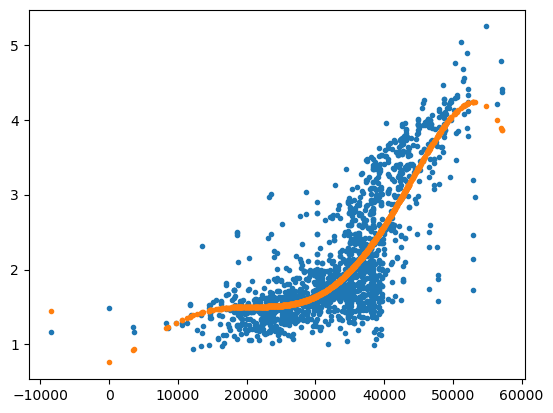

In [249]:
plt.plot(x_data, y_data, '.')
#plt.plot(x_fit, func(x_fit, params[0], params[1], params[2]), '.')
plt.plot(x_fit, np.sum([x_fit**n*coef_ghg_2030[k-n] for n in range(k+1)], axis=0), '.')

x:\user\dekkerm\environments\MyEnv\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning:

All-NaN slice encountered



Text(0, 0.5, 'Temperature rise by 2100')

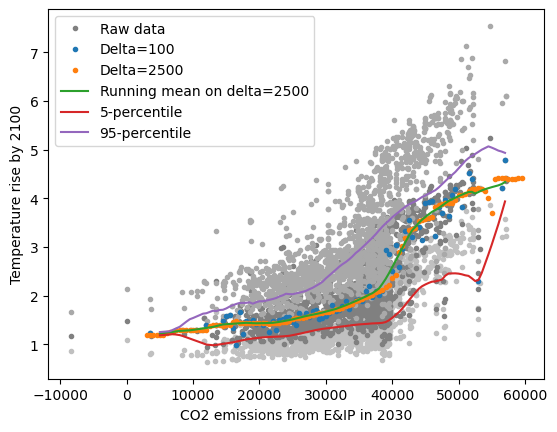

In [250]:
plt.plot(xr_ar6_2.sel(Time=2030, Variable='Emissions|CO2|Energy and Industrial Processes').Value,
         xr_ar6_2.sel(Time=2100, Variable='AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|5.0th Percentile').Value, '.', c='silver')
plt.plot(xr_ar6_2.sel(Time=2030, Variable='Emissions|CO2|Energy and Industrial Processes').Value,
         xr_ar6_2.sel(Time=2100, Variable='AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile').Value, '.', c='grey', label='Raw data')
plt.plot(xr_ar6_2.sel(Time=2030, Variable='Emissions|CO2|Energy and Industrial Processes').Value,
         xr_ar6_2.sel(Time=2100, Variable='AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|95.0th Percentile').Value, '.', c='darkgrey')
plt.plot(np.arange(1000, 100000, 500), [emis2030_to_temp_converter(y, delta=100)[0] for y in np.arange(1000, 100000, 500)], '.', label='Delta=100')
plt.plot(np.arange(1000, 100000, 500), [emis2030_to_temp_converter(y, delta=2500)[0] for y in np.arange(1000, 100000, 500)], '.', label='Delta=2500')
window_size = 10
running_mean = convolve1d([emis2030_to_temp_converter(y, delta=2500)[0] for y in np.arange(1000, 100000, 500)], np.ones(window_size)/window_size, mode='constant')
plt.plot(np.arange(1000, 100000, 500), running_mean, label='Running mean on delta=2500')
running_mean = convolve1d([emis2030_to_temp_converter(y, delta=2500)[1] for y in np.arange(1000, 100000, 500)], np.ones(window_size)/window_size, mode='constant')
plt.plot(np.arange(1000, 100000, 500), running_mean, label='5-percentile')
running_mean = convolve1d([emis2030_to_temp_converter(y, delta=2500)[2] for y in np.arange(1000, 100000, 500)], np.ones(window_size)/window_size, mode='constant')
plt.plot(np.arange(1000, 100000, 500), running_mean, label='95-percentile')
plt.legend(loc='upper left')
plt.xlabel('CO2 emissions from E&IP in 2030')
plt.ylabel('Temperature rise by 2100')

Compute global version of NDCs by computing the percentage of 2030-allocation that a country gets and extrapolating its NDC emissions towards the globe.

In [251]:
rules = ['GF', 'PC', 'PCC', 'ECPC', 'AP', 'GDR']
percs = (xr_total[rules] / xr_total.sel(Region=countries_iso)[rules].sum(dim='Region')).mean(dim='Temperature')

In [252]:
ndc_globalversion_raw = xr_total.CO2_ndc.sel(Time=2030)/percs.sel(Time=2030)

In [253]:
condition = ndc_globalversion_raw < 10000
mod_data = ndc_globalversion_raw.where(~condition, 10000)

condition = mod_data > 50000
ndc_globalversion = mod_data.where(~condition, 50000)

In [254]:
for n in range(k+1):
    if n == 0:
        xr_temps = ndc_globalversion**n*coef_ghg_2030[k-n]
    else:
        xr_temps +=  ndc_globalversion**n*coef_ghg_2030[k-n]

Add to the xarray

In [255]:
xr_total = xr_total.assign(GF_temp = xr_temps.GF)
xr_total = xr_total.assign(PC_temp = xr_temps.PC)
xr_total = xr_total.assign(PCC_temp = xr_temps.PCC)
xr_total = xr_total.assign(ECPC_temp = xr_temps.ECPC)
xr_total = xr_total.assign(AP_temp = xr_temps.AP)
xr_total = xr_total.assign(GDR_temp = xr_temps.GDR)

## Import also ENGAGE scenarios

In [256]:
df_eng = pd.read_csv(paths['data_external']+'ENGAGE/PolicyScenarios/engage-internal_snapshot_1692628962.csv')
df_eng = df_eng[df_eng.Variable == 'Emissions|CO2|Energy and Industrial Processes']
df_eng = df_eng.reset_index(drop=True)

In [257]:
regions_df = np.array(df_eng.Region)
regions_df[regions_df == "Argentine Republic"] = 'ARG'
regions_df[regions_df == "Canada"] = 'CAN'
regions_df[regions_df == "Commonwealth of Australia"] = 'AUS'
regions_df[regions_df == "Federative Republic of Brazil"] = 'BRA'
regions_df[regions_df == "People's Repulic of China"] = 'CHN'
regions_df[regions_df == "European Union (28 member countries)"] = 'EU'
regions_df[regions_df == "Republic of India"] = 'IND'
regions_df[regions_df == "Republic of Indonesia"] = 'IDN'
regions_df[regions_df == "State of Japan"] = 'JPN'
regions_df[regions_df == "Russian Federation"] = 'RUS'
regions_df[regions_df == "Kingdom of Saudi Arabia"] = 'SAU'
regions_df[regions_df == "Republic of South Africa"] = 'ZAF'
regions_df[regions_df == "Republic of Korea (South Korea)"] = 'KOR'
regions_df[regions_df == "United Mexican States"] = 'MEX'
regions_df[regions_df == "Republic of Turkey"] = 'TUR'
regions_df[regions_df == "United States of America"] = 'USA'
regions_df[regions_df == "Viet Nam "] = 'VNM'
df_eng.Region = regions_df

In [258]:
curpol = "GP_CurPol_T45"
ndc = "GP_NDC2030_T45"
nz = "GP_Glasgow"

df_eng_ref = df_eng[['Model', 'Scenario', 'Region']+list(df_eng.keys()[5:])]
df_eng_ref = df_eng_ref[df_eng_ref.Scenario.isin([curpol, ndc, nz])]
scen = np.array(df_eng_ref.Scenario)
scen[scen == ndc] = 'NDC'
scen[scen == curpol] = 'CurPol'
scen[scen == nz] = 'NetZero'
reg = np.array(df_eng_ref.Region)
reg[reg == 'World'] = 'WORLD'
df_eng_ref['Scenario'] = scen
df_eng_ref['Region'] = reg
dummy = df_eng_ref.melt(id_vars=["Scenario", "Model", "Region"], var_name="Time", value_name="Value")
dummy['Time'] = np.array(dummy['Time'].astype(int))
dummy = dummy.set_index(["Scenario", "Model", "Region", "Time"])
xr_eng = xr.Dataset.from_dataframe(dummy)
xr_eng = xr_eng.reindex(Time = np.arange(1850, 2101))
xr_eng = xr_eng.interpolate_na(dim="Time", method="linear")

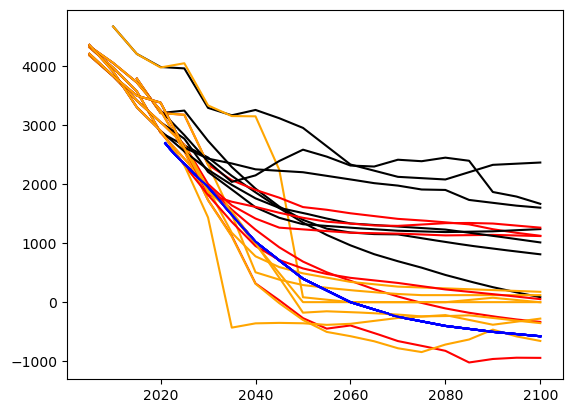

In [259]:
reg = 'EU'
for m in xr_eng.Model:
    plt.plot(xr_eng.Time, xr_eng.sel(Scenario='CurPol', Model=m, Region=reg).Value, 'k')
    plt.plot(xr_eng.Time, xr_eng.sel(Scenario='NDC', Model=m, Region=reg).Value, 'r')
    plt.plot(xr_eng.Time, xr_eng.sel(Scenario='NetZero', Model=m, Region=reg).Value, c='orange')
    plt.plot(xr_eng.Time, xr_total.GF.sel(Region=reg, **standard_settings, Temperature='1.5 deg'), c='blue')

In [260]:
xr_total = xr_total.assign(NDC = xr_eng['Value'].sel(Scenario='NDC'))
xr_total = xr_total.assign(CurPol = xr_eng['Value'].sel(Scenario='CurPol'))
xr_total = xr_total.assign(NetZero = xr_eng['Value'].sel(Scenario='NetZero'))
xr_total = xr_total.reindex(Time = np.arange(1850, 2101))
xr_total = xr_total.interpolate_na(dim="Time", method="linear")

## Save XR

In [261]:
xr_total.to_netcdf(paths['task']+'Data/xr_total.nc')

## Plots and saving

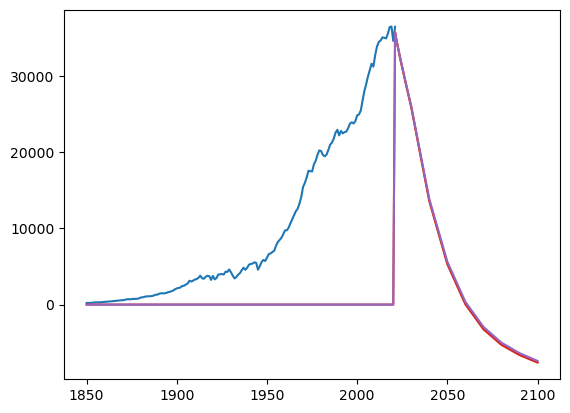

In [262]:
plt.plot(xr_total.Time, xr_total.CO2_hist.sel(Region="WORLD"))
plt.plot(xr_total.Time, xr_total.CO2_globe.sel(Temperature='1.5 deg', **standard_settings))
plt.plot(xr_total.Time, xr_total.CO2_base.sel(Region="WORLD", Scenario='SSP2'))
plt.plot(xr_total.Time, xr_total.AP.sel(Region=countries_iso, Scenario='SSP2', Temperature='1.5 deg', **standard_settings).sum(dim='Region'))
plt.plot(xr_total.Time, xr_total.GDR.sel(Region=countries_iso, Scenario='SSP2', Temperature='1.5 deg', **standard_settings).sum(dim='Region'))

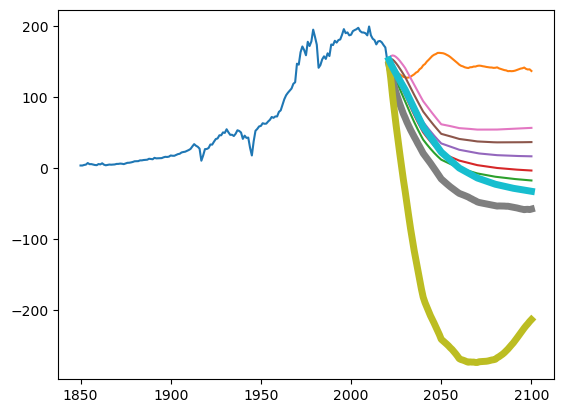

In [263]:
reg = 'NLD'
plt.plot(xr_total.Time, xr_total.CO2_hist.sel(Region=reg))
plt.plot(xr_total.Time, xr_total.CO2_base.sel(Region=reg, Scenario='SSP2'))
for c_i, c in enumerate(xr_total.Temperature):
    plt.plot(xr_total.Time, xr_total.PCC.sel(Region=reg, Temperature=c, Scenario='SSP2', Convergence_year=2050, **standard_settings))
plt.plot(xr_total.Time, xr_total.AP.sel(Region=reg, Temperature='1.5 deg', Scenario='SSP2', **standard_settings), lw=5)
plt.plot(xr_total.Time, xr_total.GDR.sel(Region=reg, Temperature='1.5 deg', Scenario='SSP2', **standard_settings), lw=5)
plt.plot(xr_total.Time, xr_total.GF.sel(Region=reg, Temperature='1.5 deg', **standard_settings), lw=5)

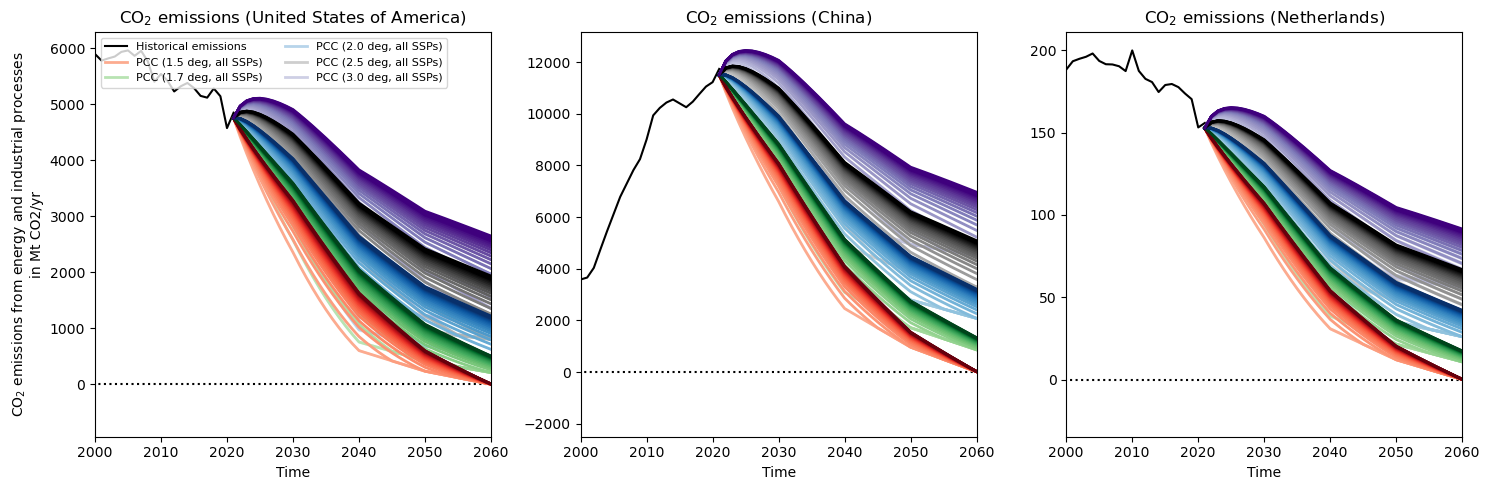

In [265]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax_i, ax in enumerate(axes):
    country = ['USA', 'CHN', 'NLD'][ax_i]
    ax.plot(xr_total.Time, xr_total.sel(Region=country).CO2_hist, c='k', label='Historical emissions')
    #ax.plot(np.arange(params['start_year_analysis'], 2101), xr_total.sel(Region=country, Scenario='SSP2', Temperature='1.5 deg', Time=np.arange(params['start_year_analysis'], 2101)).CO2_base, c='silver', label='Baseline emissions')
    for method_i, method in enumerate(['PCC']):
        for year_i, year in enumerate(xr_total.Convergence_year):
            for temp_i, temp in enumerate(np.array(xr_total.Temperature)):
                colmap = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Greys, plt.cm.Purples][temp_i]
                max = xr_total.sel(Region=country, Convergence_year=year, Temperature=temp, **standard_settings)[method].max(dim='Scenario')
                min = xr_total.sel(Region=country, Convergence_year=year, Temperature=temp, **standard_settings)[method].min(dim='Scenario')
                col = colmap(0.3+year_i/(len(xr_total.Convergence_year)*1.2))
                ax.fill_between(xr_total.Time, min, max, where=max>=min, alpha=0.4, facecolor=col, zorder=1e9)
                if year_i == 0 and method_i == 0:
                    ax.plot(xr_total.Time, (max+min)/2, color=col, label=method+' ('+temp+', all SSPs)', zorder=1e9, lw=2)
                else:
                    ax.plot(xr_total.Time, (max+min)/2, color=col, zorder=1e9, lw=2)
    ax.set_xlim(ax.get_xlim())
    ax.plot(ax.get_xlim(), [0, 0], 'k:')
    ax.set_xlabel('Time')
    ax.set_title('CO$_2$ emissions ('+countries_name[countries_iso == country][0]+')')
    ax.set_xlim([2000, 2060])
axes[0].legend(loc='upper left', fontsize=8, ncol=2)
axes[0].set_ylabel('CO$_2$ emissions from energy and industrial processes\nin Mt CO2/yr')
fig.tight_layout()

In [266]:
df = pd.read_excel("X:/user/dekkerm/Data/UNFCCC_Parties_Groups_noeu.xlsx", sheet_name = "Country groups")
countries_iso = np.array(df["Country ISO Code"])
group_cvf = countries_iso[np.array(df["CVF (24/10/22)"]) == 1]
group_g20 = countries_iso[np.array(df["G20"]) == 1]
group_eu = countries_iso[np.array(df["EU"]) == 1]
group_g7 = countries_iso[np.array(df["G7"]) == 1]
group_na = countries_iso[np.array(df["Northern America"]) == 1]
group_um = countries_iso[np.array(df["Umbrella"]) == 1]
group_au = countries_iso[np.array(df["Australasia"]) == 1]
group_af = countries_iso[np.array(df["African Group"]) == 1]
group_sids = countries_iso[np.array(df["SIDS"]) == 1]
group_ldc = countries_iso[np.array(df["LDC"]) == 1]
group_eg = countries_iso[np.array(df["European Group"]) == 1]

In [267]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}]],
                                    horizontal_spacing = 0,
                                    vertical_spacing=0)

colorbar_abs = dict(len=1, x=1, tickvals = [0, 1, 2, 3], ticktext = ['1', '10', '100', '1000'])
colorbar_pc = dict(len=1, x=1)

allvals = xr_total.sel(Region=group_eu, Time=np.arange(params['start_year_analysis'], 2101), Convergence_year=[2050, 2075, 2100], Temperature='1.5 deg', Scenario='SSP2', **standard_settings).sum(dim='Time')['PCC']/1e3

mn = np.min(allvals)
mx = np.max(allvals)

for year_i, year in enumerate([2050, 2075, 2100]):
    if year_i == 0:
        cm= True
    else:
        cm= False
    vals = allvals.sel(Convergence_year=year)
    fig.add_trace(
        go.Choropleth(
        locations=group_eu,
        z = vals,
        locationmode = 'ISO-3',
        colorscale = 'Blues',
        zmax = float(mx),
        zmin = float(mn),
        text = [str(countries_name[countries_iso == r][0])+": "+str(np.round(float(vals.sel(Region=r)), 2))+" Gt CO2" for r_i, r in enumerate(group_eu)],
        hovertemplate  = '%{text}',
        name="",
        marker_line_color='white', 
        marker_line_width=0.2,
        colorbar=dict(len=0.9, x=1, tickvals = [0, 1, 2, 3, 4, 5, 6, 7], title={"text":"CO2 budget<br>2022-2100<br>(Gt CO2)"}, tickfont={'size': 25}),
        showscale=cm
    ), [1, 1, 1, 2, 2, 2][year_i], [1, 2, 3, 1, 2, 3][year_i])

    vals_n = np.array(((vals - mn)/(mx - mn)))*2+8
    vals_boolean = np.copy(vals)
    vals_boolean[vals >= 0] = 1
    vals_boolean[vals < 0] = 0
    vals_boolean = vals_boolean.astype(int)
    
    fig.add_scattergeo(
                locations = group_eu,
                text = vals.round(2),
                featureidkey="properties.NAME_3",
                mode = 'text',
                hoverinfo='skip',
                showlegend=False,
                textfont={'size': vals_n,
                          'color': np.array(['darkred', 'black'])[vals_boolean]},
                row=[1, 1, 1, 2, 2, 2][year_i],
                col=[1, 2, 3, 1, 2, 3][year_i])

fig.update_geos(visible=False,
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                projection_type='natural earth',
                resolution=50,
                lataxis_range=[30,75], lonaxis_range=[-20, 40],
                showcoastlines=False,)
# fig.update_geos(showocean=True, oceancolor="white")
# fig.update_geos(showlakes=True, lakecolor="white")

# limite map scope to USA 'africa', 'asia', 'europe', 'north america', 'south america', 'usa', 'world'
fig.update_layout(
    geo1 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo2 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo3 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,)
)

#fig.update_traces(showscale=False)
fig.update_layout(height=600, width=2000)
fig.update_geos(visible=True, showcountries=False)#fitbounds="locations",
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.96, x=0.03, text="<b>(a) PCC (2050)</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.96, x=0.43, text="<b>(b) PCC (2075)</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.96, x=0.94, text="<b>(c) PCC (2100)</b>")
fig_europe = fig
fig.show()

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_5644\2234478485.py:38: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_5644\2234478485.py:39: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_5644\2234478485.py:38: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either i